# Exercise 2.3

First of all, we import usefull libraries.

In [1]:
import numpy as np
import pydot
from IPython.display import Image

Compared to the previous methods, we do the same, but in the opposite direction. We setup the same data, but the current dendrogram contains the whole data set as one cluster.

In [2]:
tree = pydot.Dot(graph_type='graph')

def calculate_distance(x,v):
    return np.sqrt((x[0]-v[0])**2+(x[1]-v[1])**2)


def calculate_centroid(dendrogram_elements):
    if type(dendrogram_elements) is list:
        sumof=np.zeros(len(dendrogram_elements[0]))
        for iter in range(len(dendrogram_elements)):
            sumof=np.add(sumof,np.array(dendrogram_elements[iter]))
        if sumof.shape == (len(data_set[0]),len(data_set[0])):
            pass
        return np.divide(sumof*1.0, len(dendrogram_elements)*1.0)
    else:
        return dendrogram_elements

We use a more efficient solution for the distance matrix calculation. In the following example, we calculate it once and extract the distances every time needed. This is why the below method is invoked only once.

In [3]:
def calculate_dendogram_distance_matrix_diana():
    distance_matrix=np.zeros((len(data_set), len(data_set)))
    for i in range(len(data_set)):
        for j in range(len(data_set)):
            distance_matrix[i, j] = calculate_distance(calculate_centroid(data_set[i]),calculate_centroid(data_set[j]))
    return distance_matrix

There are two new methods that need to be implemented. The first one returns the cluster that needs to be divided:

In [4]:
def choose_cluster(current_level, distance_matrix):
    if type(current_level[0]) != list:
        both_idx = np.array(current_level)
        current = distance_matrix[both_idx[:,None], both_idx]
        diff = np.sum(current) / (current.shape[0] * current.shape[1] - len(current))
        return current_level, diff, 0
    highest_diff = 0
    cluster_id = 0
    for i in range(len(current_level)):
        both_idx = np.array(current_level[i])
        current = distance_matrix[both_idx[:, None], both_idx]
        diff = np.sum(current) / (current.shape[0] * current.shape[1]-len(current))
        if diff > highest_diff:
            highest_diff = diff
            cluster_id = i
    return current_level[cluster_id], highest_diff, cluster_id

The second method split the cluster into two clusters by counting the closest distances to each object in the cluster. Objects in both clusters are the closest ones.

In [5]:
def split(split_cluster, distance_matrix, diff):
    if len(split_cluster) == 2:
        cluster1 = [split_cluster[0]]
        cluster2 = [split_cluster[1]]
        return cluster1, cluster2
    split_threshold = diff
    both_idx = np.array(split_cluster)
    distances = distance_matrix[both_idx[:, None], both_idx]
    c1keys, c1counts = np.unique(np.argwhere(distances > split_threshold), return_counts=True)
    c2keys, c2counts = np.unique(np.argwhere(distances <= split_threshold), return_counts=True)
    cluster1_counts = dict(zip(np.array(split_cluster)[c1keys], c1counts))
    cluster2_counts = dict(zip(np.array(split_cluster)[c2keys], c2counts))
    cluster1 = []
    cluster2 = []
    choice = 0
    for item in split_cluster:
        if item not in cluster1_counts.keys():
            cluster2.append(item)
            continue
        if item not in cluster2_counts.keys():
            cluster1.append(item)
            continue
        if cluster1_counts[item] < cluster2_counts[item]:
            cluster2.append(item)
        elif cluster1_counts[item] > cluster2_counts[item]:
            cluster1.append(item)
        else:
            if choice == 0:
                cluster2.append(item)
                choice = 1
            else:
                cluster1.append(item)
                choice = 0
    return cluster1, cluster2

Combine it all together:

In [6]:
def cluster():
    dendrograms_history=[]
    current_dendrograms=[list(range(len(data_set)))]
    distance_matrix = calculate_dendogram_distance_matrix_diana()
    while len(current_dendrograms) != len(data_set):
        current_level = current_dendrograms[-1]
        current_cluster, diff, cluster_id = choose_cluster(current_level, distance_matrix)
        cluster1, cluster2 = split(current_cluster, distance_matrix, diff)
        if type(current_level[0]) != list:
            current_dendrograms.append([cluster1, cluster2])
        else:
            rest = current_level.copy()
            rest.pop(cluster_id)
            rest.append(cluster1)
            rest.append(cluster2)
            current_dendrograms.append(rest)
        hist = [{"acesor": current_cluster, "childs": [cluster1,cluster2]}]
        dendrograms_history.append(hist)
    return dendrograms_history

We get the dendrogram levels with:

In [7]:
%store -r data_set 
dendrogram_hist_diana = cluster()

/Users/Manuela/anaconda2/envs/py3/lib/python3.5/site-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in double_scalars
  if sys.path[0] == '':


The method that draw the dendrogram is a bit different compared to the agglomerative method:

In [8]:
def show_tree_divisive():
    for item in dendrogram_hist_diana:
        for child in item[0]["childs"]:
            new_edge = pydot.Edge(str(item[0]["acesor"]),str(child))
            tree.add_edge(new_edge)
    tree.write('tree_diana.png',format='png')

show_tree_divisive()

We can display the dendrogram the same as in the previous example:

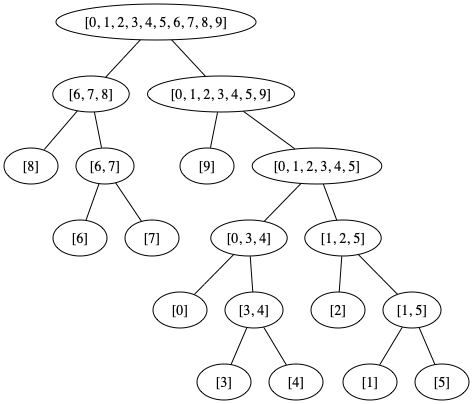

In [9]:
Image(filename='Images/tree_diana.png')